# Goal

Detect vehicles.

# Sliding-window

In [7]:
from sklearn.externals import joblib
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
%matplotlib inline

In [8]:
def read_image(file_name):
    img = cv2.imread(file_name)
    return np.dstack((img[:, :, 2], img[:, :, 1], img[:, :, 0]))

In [9]:
model = joblib.load('model.pkl')

In [10]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    return hog(img, orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=True,
                              block_norm='L2-Hys',
                              visualise=vis, feature_vector=feature_vec)

def get_color_hist(img, nbins=32):
    histograms = [np.histogram(img[:,:,i], bins=nbins) for i in range(img.shape[2])]
    histograms = [histogram[0] for histogram in histograms]
    return np.concatenate(histograms)

def get_color_space(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return  cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(img)

In [33]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, model, orient, pix_per_cell, cell_per_block, hist_bins):    
    img_tosearch = img[ystart:ystop,:,:]
    
    color_image = get_color_space(img_tosearch, 'HSV')
    hog_image = get_color_space(img_tosearch, 'HLS')
    imshape = color_image.shape
    
    if scale != 1:
        color_image = cv2.resize(color_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        hog_image = cv2.resize(hog_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        imshape = color_image.shape
        
    # Define blocks and steps as above
    nxblocks = (hog_image.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (hog_image.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step  + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step  + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(hog_image[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(hog_image[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(hog_image[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(color_image[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            hist_features = get_color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.hstack((hist_features, hog_features)).reshape(1, -1)   
            test_prediction = model.predict(test_features)
            
            if test_prediction[0] == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

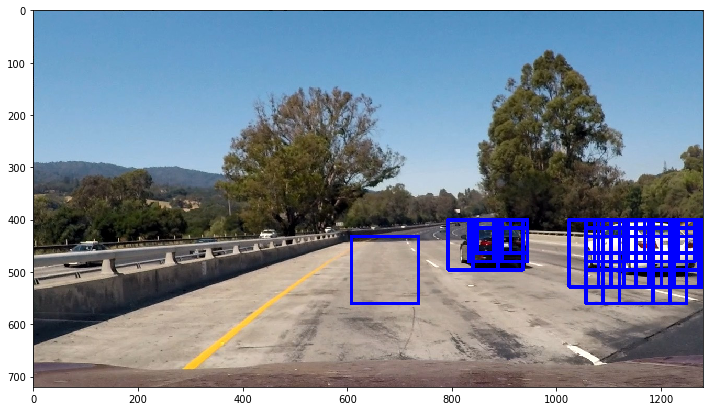

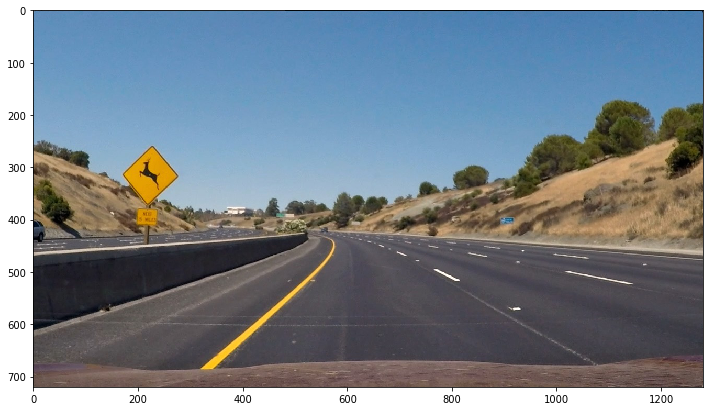

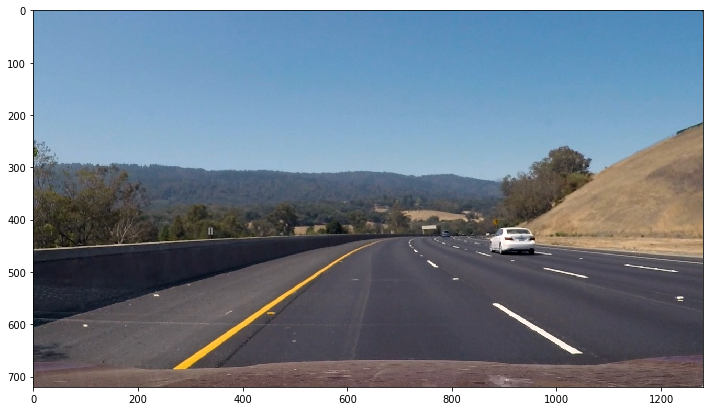

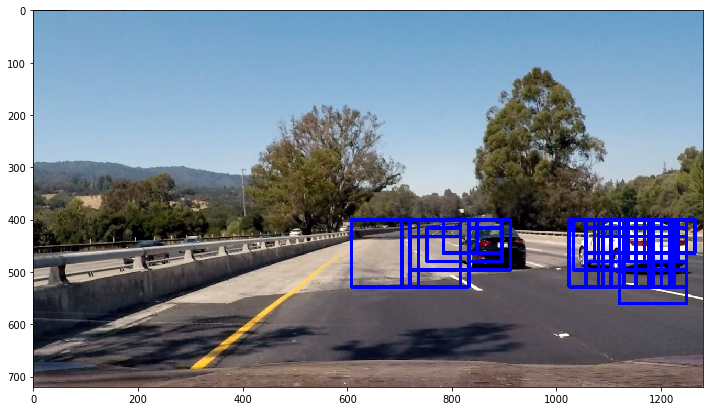

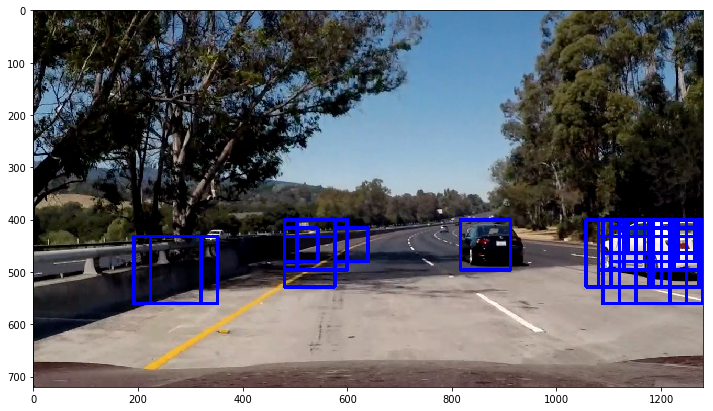

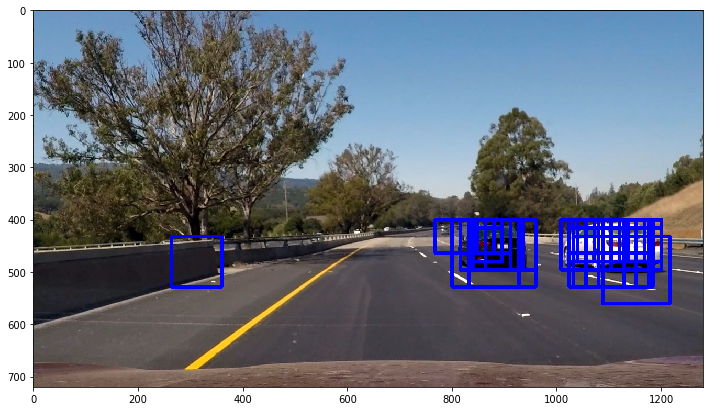

In [37]:
windows = [
    (1.0, 400, 464),
    (1.0, 416, 480),
    (1.5, 400, 496),
    (1.5, 432, 528),
    (2.0, 400, 528),
    (2.0, 432, 560),
    (3.5, 400, 596),
    (3.5, 464, 660),
]
for file_name in os.listdir('./test_images/'):
    if file_name.endswith('.jpg'):
        img = read_image(os.path.join('./test_images', file_name))
        rectangles = []
        for window in windows:
            rectangles += find_cars(img, window[1], window[2], window[0], model, 9, 8, 2, 32)
        for rectangle in rectangles:
            cv2.rectangle(img,(rectangle[0][0], rectangle[0][1]),(rectangle[1][0], rectangle[1][1]),(0,0,255),6) 
        plt.figure(figsize=(12, 12))
        plt.imshow(img)

# Headmap

In [38]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

23.0
0.0
0.0
20.0
20.0
18.0


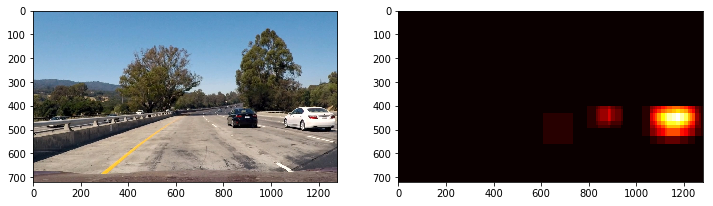

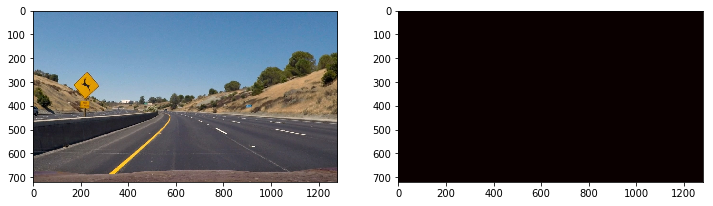

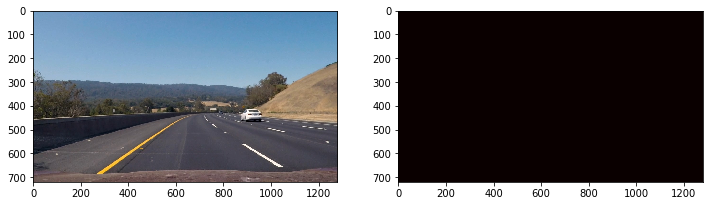

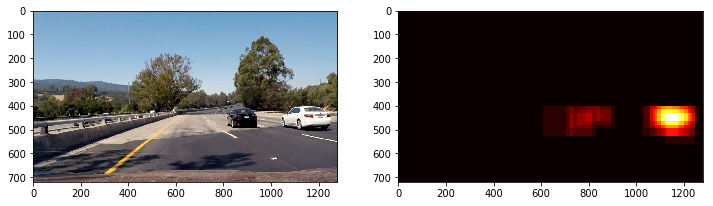

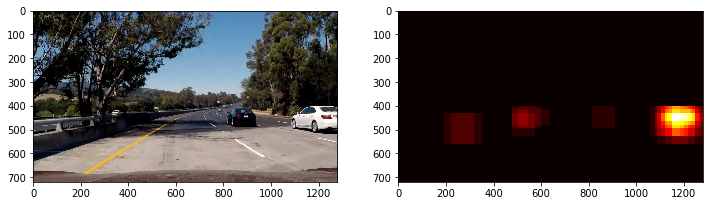

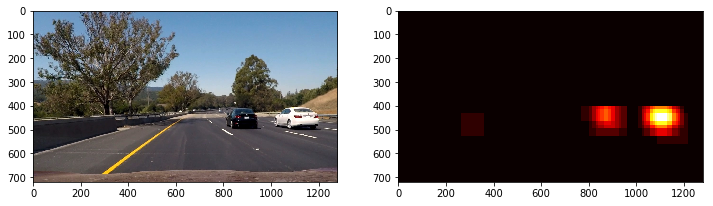

In [39]:
for file_name in os.listdir('./test_images/'):
    if file_name.endswith('.jpg'):
        img = read_image(os.path.join('./test_images', file_name))
        rectangles = []
        for window in windows:
            rectangles += find_cars(img, window[1], window[2], window[0], model, 9, 8, 2, 32)
        heatmap = np.zeros((img.shape[0], img.shape[1]))
        heatmap = add_heat(heatmap, rectangles)
        plt.figure(figsize=(12, 12))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.subplot(1, 2, 2)
        plt.imshow(heatmap, cmap='hot')
        print(np.max(heatmap))

In [40]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [41]:
from scipy.ndimage.measurements import label

2 cars found
0 cars found
0 cars found
2 cars found
2 cars found
2 cars found


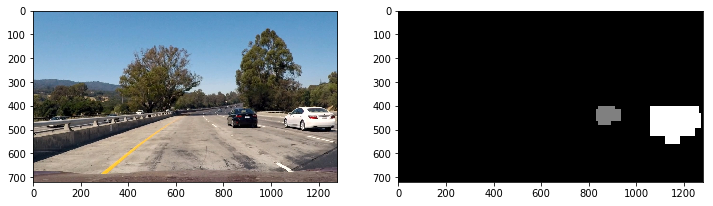

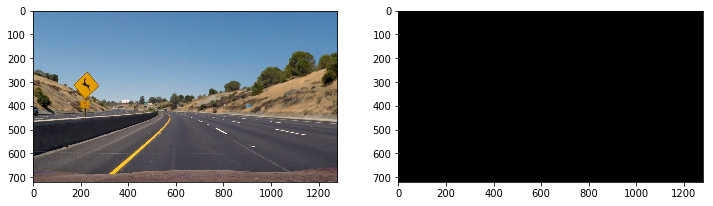

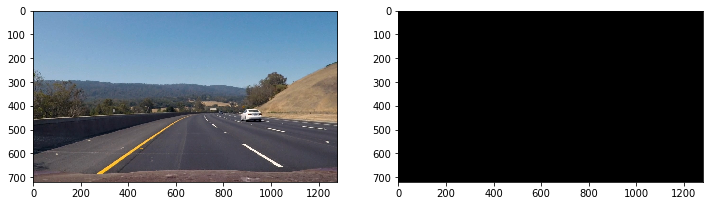

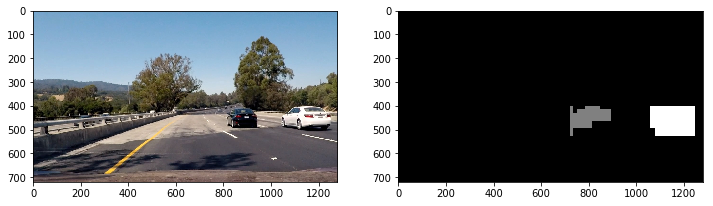

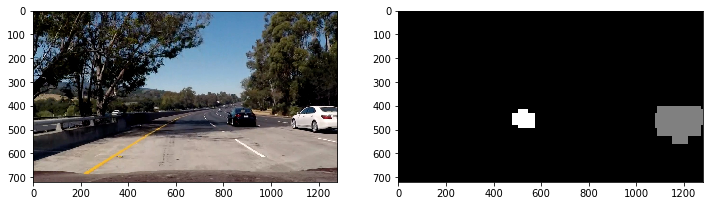

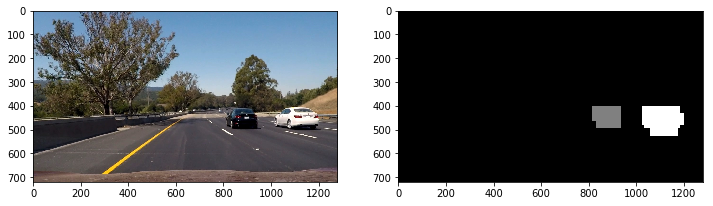

In [42]:
for file_name in os.listdir('./test_images/'):
    if file_name.endswith('.jpg'):
        img = read_image(os.path.join('./test_images', file_name))
        rectangles = []
        for window in windows:
            rectangles += find_cars(img, window[1], window[2], window[0], model, 9, 8, 2, 32)
        heatmap = np.zeros((img.shape[0], img.shape[1]))
        heatmap = add_heat(heatmap, rectangles)
        heatmap = apply_threshold(heatmap, 2)
        labels = label(heatmap)
        print(labels[1], 'cars found')
        plt.figure(figsize=(12, 12))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.subplot(1, 2, 2)
        plt.imshow(labels[0], cmap='gray')


In [43]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

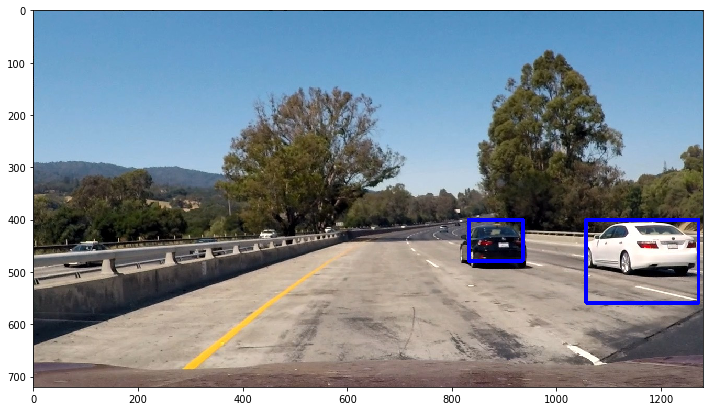

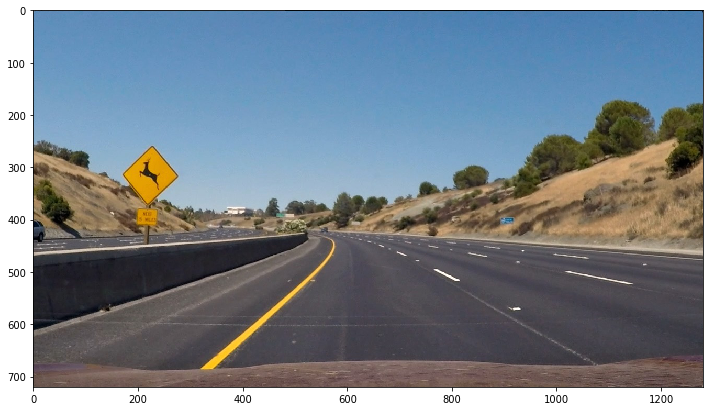

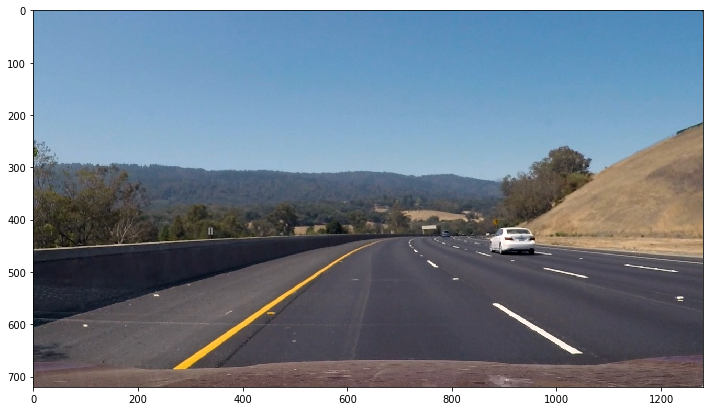

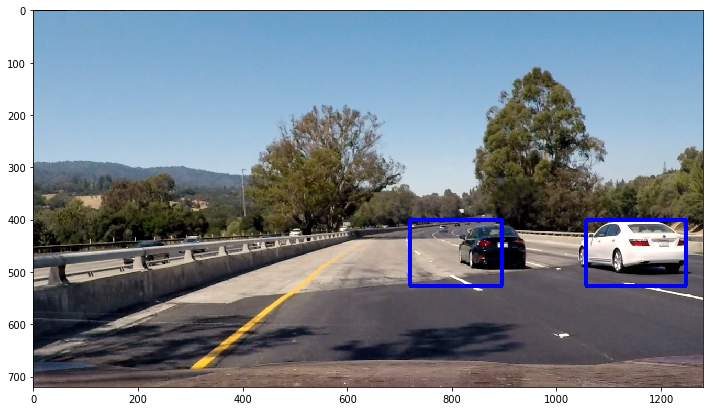

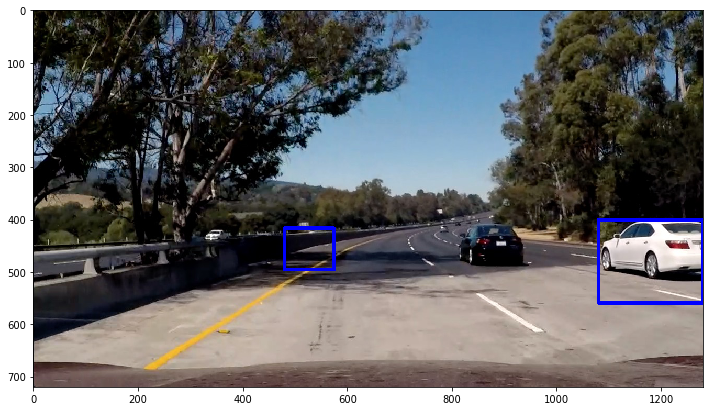

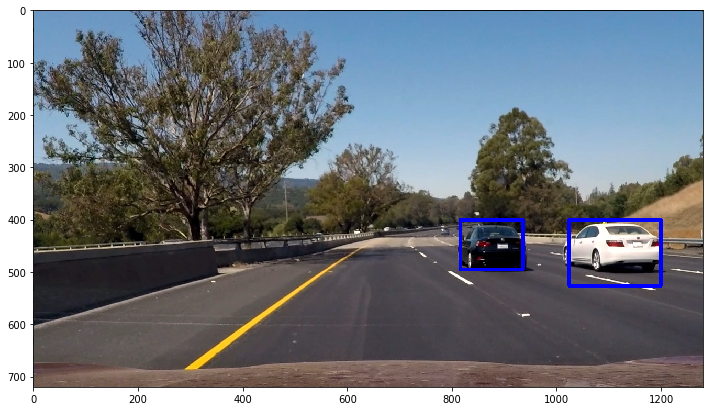

In [44]:
for file_name in os.listdir('./test_images/'):
    if file_name.endswith('.jpg'):
        img = read_image(os.path.join('./test_images', file_name))
        rectangles = []
        for window in windows:
            rectangles += find_cars(img, window[1], window[2], window[0], model, 9, 8, 2, 32)
        heatmap = np.zeros((img.shape[0], img.shape[1]))
        heatmap = add_heat(heatmap, rectangles)
        heatmap = apply_threshold(heatmap, 2)
        labels = label(heatmap)
        plt.figure(figsize=(12, 12))
        plt.imshow(draw_labeled_bboxes(img, labels))

# Run a Video Through the Pipeline (primitive version)

In [45]:
from moviepy.editor import VideoFileClip

In [47]:
def process_frame(img):
    rectangles = []
    for window in windows:
        rectangles += find_cars(img, window[1], window[2], window[0], model, 9, 8, 2, 32)
    heatmap = np.zeros((img.shape[0], img.shape[1]))
    heatmap = add_heat(heatmap, rectangles)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    return draw_labeled_bboxes(img, labels)

In [48]:
test_out_file = './output_images/test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:36<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 37 s, sys: 938 ms, total: 37.9 s
Wall time: 37.8 s


In [50]:
from IPython.display import HTML

In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))